<a href="https://colab.research.google.com/github/KhyatiMahendru/StockPricePrediction/blob/master/AIProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [0]:
!pip install --upgrade -q gspread

In [0]:
import gspread

In [0]:
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
worksheet = gc.open('googl1').sheet1

In [0]:
rows = worksheet.get_all_values()
data = pd.DataFrame.from_records(rows)
data.columns = data.iloc[0]
data = data.drop(0).reset_index(drop = True)

data.head()

,Date,Close
0,19/08/2004 16:00:00,50.17
1,20/08/2004 16:00:00,54.16
2,23/08/2004 16:00:00,54.7
3,24/08/2004 16:00:00,52.44
4,25/08/2004 16:00:00,53


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3677 entries, 0 to 3676
Data columns (total 2 columns):
Date     3677 non-null object
Close    3677 non-null object
dtypes: object(2)
memory usage: 57.5+ KB


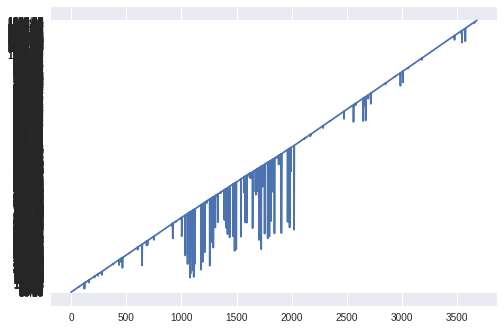

In [0]:
plt.plot(data['Close'])
plt.show()

In [0]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [0]:
train_len = int(0.67 * len(data))
train = data.iloc[0:train_len, :].drop(['Date'], axis = 1)
test = data.iloc[train_len:, :].drop(['Date'], axis = 1).reset_index(drop = True)

print(len(train), len(test))
train.head()

2463 1214


,Close
0,50.17
1,54.16
2,54.7
3,52.44
4,53


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset.iloc[i:(i+look_back), 0]
		dataX.append(np.array(a))
		dataY.append(np.array(dataset.iloc[i + look_back, 0]))
	return np.array(dataX), np.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
len(trainX)

2461

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
model = Sequential()
model.add(LSTM(
        50,
        input_shape = (1, look_back),
        return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
        100,
        return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation("linear"))

model.compile(loss="mse", optimizer="rmsprop")
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/400
 - 9s - loss: 61043.7676
Epoch 2/400
 - 6s - loss: 32112.2278
Epoch 3/400
 - 6s - loss: 16507.5433
Epoch 4/400
 - 6s - loss: 9641.7488
Epoch 5/400
 - 6s - loss: 6752.9312
Epoch 6/400
 - 6s - loss: 5438.9744
Epoch 7/400
 - 6s - loss: 4512.4693
Epoch 8/400
 - 6s - loss: 3872.0232
Epoch 9/400
 - 6s - loss: 3441.3275
Epoch 10/400
 - 6s - loss: 3266.1441
Epoch 11/400
 - 6s - loss: 2901.5448
Epoch 12/400
 - 6s - loss: 2565.3175
Epoch 13/400
 - 6s - loss: 2539.8772
Epoch 14/400
 - 6s - loss: 2438.8637
Epoch 15/400
 - 6s - loss: 2400.8113
Epoch 16/400
 - 6s - loss: 2314.5118
Epoch 17/400
 - 6s - loss: 2295.9263
Epoch 18/400
 - 6s - loss: 2123.9667
Epoch 19/400
 - 6s - loss: 2104.3176
Epoch 20/400
 - 6s - loss: 2131.2104
Epoch 21/400
 - 6s - loss: 2081.5575
Epoch 22/400
 - 6s - loss: 1958.4286
Epoch 23/400
 - 6s - loss: 1811.2518
Epoch 24/400
 - 6s - loss: 1866.1906
Epoch 25/400
 - 6s - loss: 1869.7967
Epoch 26/400
 - 6s - loss: 1842.3

In [0]:
# Estimate model performance
import math
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 26.75 MSE (5.17 RMSE)
Test Score: 169.03 MSE (13.00 RMSE)


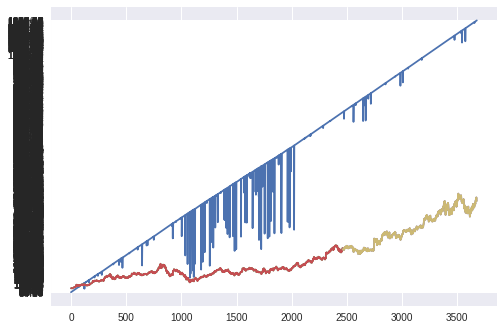

In [0]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(data.iloc[:, 1])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()